<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 5 - Support Vector Machine Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Scikit-Learn Support Vector Machine Classifier](#sklearn-svm)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Calibration with Platt Scaling](#calibration)  
[Summary](#summary)

# Support Vector Machine Classifier Introduction <a class="anchor" id="introduction"></a>
Support vector machines (SVM) can be used for discriminative supervised classification or regression. At their essence, SVMs perform binary classification by constructing an optimal hyperplane to separate the training data with as big a margin possible. New data are classified according to which side of the hyperplane they fall onto. In this sense, SVMs are _not_ probabilistic models. Nevertheless, SVMs find many applications from image classification to bioinformatics. This is mainly due to SVMs ability to handle high-dimensional data and model _non-linear_ relationships by use of the so-called "kernel trick". In the case of the povery data, SVMs will be used in their canonical form, as binary classifiers.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** The SVM algorithm doesn't just seek a linear separation of the data, it seeks the hyperplane that creates the largest possible gap –the margins– between the two classes. The data points that bound the size of the margin on either side of the hyperplane are called _support vectors_.

**Algorithm and Training.** The optimal hyperplane is found by solving a Lagrangian dual quadratic programming problem. For this reason, SVMs can be slow to train, but since they are deterministic models, they classify particularly fast once trained.

<img src="http://docs.opencv.org/2.4/_images/optimal-hyperplane.png" height=350 width=350>

**Variations of the model.** There are many variations on the basic SVM model. The most common is extension of SVM to multi-class classification using one-versus-all or one-versus-one techniques similar to logistic regression. Additionally, in cases where the data are not linearly seperable the so-called "kernel trick" is used. The kernel trick implicitly maps the data to a higher-dimensional (possibly infinite-dimensional) space. In such spaces, the data may be linearly separable and a maximum-margin hyperplane can be found. Once found, the boundary is projected back into lower-dimensional space where it appears as a nonlinear decision boundary.

As noted above, SVMs are not inherently probabilistic classifiers. They are deterministic _maximum-margin classifiers_. 

## Considerations <a class="anchor" id="introduction-considerations"></a>



# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'svm'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn Support Vector Machine Model <a class="anchor" id="sklearn-svm"></a>


SVM can take a long time to run, especially on large datasets. Beause of this, we'll add a `SUBSAMPLE` variable to downsample the size of the dataset by default. To run these algorithms across all of the data, set `SUBSAMPLE = 1`. Results will not match the published results when the notebook only uses a portion of the training data.

In [3]:
SUBSAMPLE = 0.1

def subsample(X, y, w, stratify=True, seed=566):
    n_samples = int(SUBSAMPLE * X.shape[0])
    
    rng = np.random.RandomState(seed)
    
    if stratify:
        y_rate = y.mean()
        n_true = int(n_samples * y_rate)
        n_false = n_samples - n_true
        
        true_idx = rng.choice(np.where(y)[0], n_true, replace=False)
        false_idx = rng.choice(np.where(~y)[0], n_false, replace=False)
        
        sample_idx = np.union1d(true_idx, false_idx)
    else:
        sample_idx = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    
    return X.iloc[sample_idx, :], y[sample_idx], w[sample_idx]

In [4]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 767 ms
CPU times: user 32.1 ms, sys: 0 ns, total: 32.1 ms
Wall time: 70.9 ms
In-sample score: 79.41%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


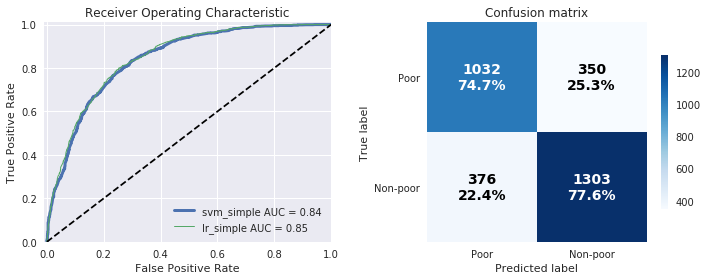

,svm_simple,lr_simple
accuracy,0.762823,0.766743
recall,0.746744,0.738784
precision,0.732955,0.743086
f1,0.739785,0.740929
cross_entropy,0.489412,0.478969
roc_auc,0.841742,0.847856
cohen_kappa,0.521933,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 58.87% 


In [5]:
# Support Vector Machines
from sklearn.svm import SVC

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## SVC with all features <a class="anchor" id="all-feats"></a>

Now let's try using the full feature set

CPU times: user 2.48 s, sys: 6.75 ms, total: 2.48 s
Wall time: 6.92 s
CPU times: user 434 ms, sys: 3.56 ms, total: 437 ms
Wall time: 910 ms
In-sample score: 87.11%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


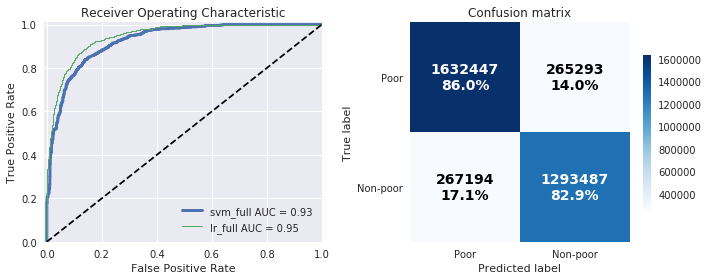

,svm_full,lr_full
accuracy,0.846032,0.873897
recall,0.860206,0.869754
precision,0.859345,0.853693
f1,0.859775,0.861649
cross_entropy,0.342397,0.288223
roc_auc,0.926992,0.948658
cohen_kappa,0.671944,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.94% 


In [6]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

The SVC model has a single parameter, `C`, we can attempt to tune. This determines the regularization strength. We can also see how different kernels perform. 

NOTE: This cell may take up to an hour to run.

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.0001, kernel=rbf ............................................
[CV] C=0.0001, kernel=rbf ............................................
[CV] C=0.0001, kernel=linear .........................................
[CV] C=0.0001, kernel=rbf ............................................
[CV] ... C=0.0001, kernel=rbf, score=0.5490196078431373, total=   2.9s
[CV] C=0.0001, kernel=linear .........................................
[CV] ... C=0.0001, kernel=rbf, score=0.5490196078431373, total=   4.6s
[CV] C=0.0001, kernel=linear .........................................
[CV]  C=0.0001, kernel=linear, score=0.5490196078431373, total=   4.7s
[CV] C=0.03162277660168379, kernel=rbf ...............................
[CV] ... C=0.0001, kernel=rbf, score=0.5490196078431373, total=   5.1s
[CV] C=0.03162277660168379, kernel=rbf ...............................
[CV]  C=0.0001, kernel=linear, score=0.5490196078431373, total=   3.2s
[CV] C=0.03162277

[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   15.4s finished


CPU times: user 1.84 s, sys: 81.1 ms, total: 1.93 s
Wall time: 19.5 s
CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 427 ms
In-sample score: 91.94%
Best model parameters: {'C': 0.03162277660168379, 'kernel': 'linear'}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


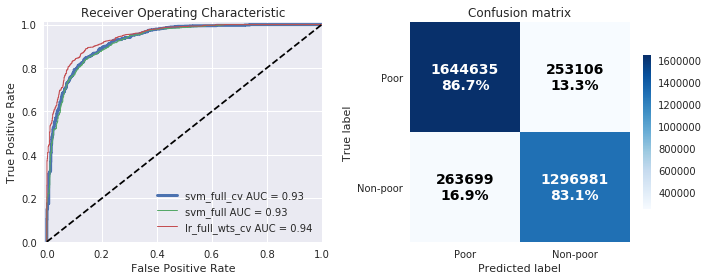

,svm_full_cv,svm_full,lr_full_wts_cv
accuracy,0.850566,0.846032,0.873458
recall,0.866628,0.860206,0.891581
precision,0.861817,0.859345,0.87947
f1,0.864216,0.859775,0.885484
cross_entropy,0.334314,0.342397,0.300498
roc_auc,0.930179,0.926992,0.944474
cohen_kappa,0.697015,0.671944,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.06% 


In [7]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# build the model
estimator = SVC(probability=True)
parameters = {'C': 10**np.linspace(-4,1,3), 
              'kernel': ['rbf', 'linear']}
model = GridSearchCV(estimator, parameters, cv=3, verbose=3, n_jobs=4)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)
best_model = model

# Classifier Calibration with Isotonic Regression <a class="anchor" id="calibration"></a>

We introduced classifier calibration in the Naive Bayes Malawi notebook. Here, we will apply a different type of calibration, isotonic regression, to see if we can improve our model performance. In Scikit-Learn, this simply involves changing the `method` parameter of the CalibratedClassifierCV to 'isotonic'.

CPU times: user 2.27 s, sys: 6.16 ms, total: 2.27 s
Wall time: 4.6 s
CPU times: user 508 ms, sys: 0 ns, total: 508 ms
Wall time: 1.39 s
In-sample score: 92.16%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


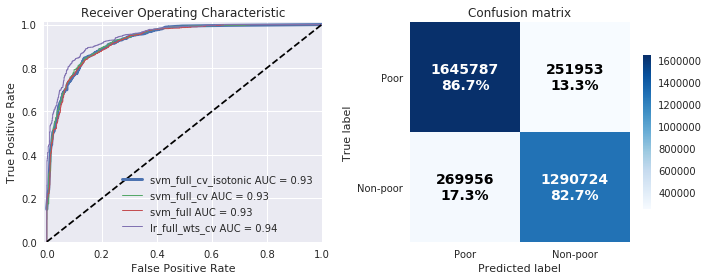

,svm_full_cv_isotonic,svm_full_cv,svm_full,lr_full_wts_cv
accuracy,0.84909,0.850566,0.846032,0.873458
recall,0.867235,0.866628,0.860206,0.891581
precision,0.859086,0.861817,0.859345,0.87947
f1,0.863141,0.864216,0.859775,0.885484
cross_entropy,0.395003,0.334314,0.342397,0.300498
roc_auc,0.928654,0.930179,0.926992,0.944474
cohen_kappa,0.693702,0.697015,0.671944,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.19% 


In [8]:
from sklearn.calibration import CalibratedClassifierCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Calibrate the model
model = CalibratedClassifierCV(best_model.best_estimator_, method='isotonic')
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full_cv',
                                                    'svm_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv_isotonic', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# SVM Malawi Summary <a class="anchor" id="summary"></a>



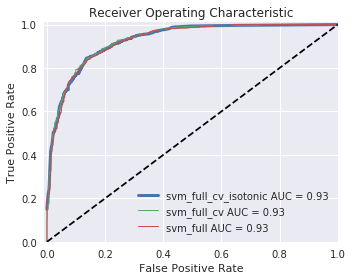

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
svm_full_cv_isotonic,0.84909,0.867235,0.859086,0.863141,0.395003,0.928654,0.693702,0.0108429
svm_full_cv,0.850566,0.866628,0.861817,0.864216,0.334314,0.930179,0.697015,0.00952429
svm_full,0.846032,0.860206,0.859345,0.859775,0.342397,0.926992,0.671944,0.00829953


In [9]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)